# Proyecto Análisis de datos y Proyección de Demanda



En el presente informe, se analiza el dataset "Prueba Planning - Control de Gestión.xlsx", específicamente la hoja "Datos", que contiene información detallada sobre la venta de distintos SKU en varios países.

A partir de esta información, se realizó un análisis exploratorio para identificar los SKUs más vendidos por país, determinar los canales más eficientes según distintos criterios (como rentabilidad, rotación y devoluciones), y proponer una estrategia de asignación de productos que maximice el valor generado. 



## 1. Análsis exploratorio de la Data (EDA)

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from collections import defaultdict
import locale
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

 



Tras abrir el excel y revisar la data, se establece que los nombres de la columna corresponden a la fila 4. Con este objetivo, se establece el _head_ de cada columna en esta fila: 

In [33]:
file_path = "Prueba Planning - Control de Gestión.xlsx"
df = pd.read_excel(file_path, sheet_name = "Datos", header=3)

print(df.head())



    País      Fecha       SKU        Nro. Orden   Canal Tipo de Despacho  \
0  CHILE 2025-03-01  BA033007     23358234801-A  RIPLEY   No Fulfillment   
1  CHILE 2025-03-01  BA381431  2000007288189341    MELI      Fulfillment   
2  CHILE 2025-03-01  BA381431  2000007288757447    MELI      Fulfillment   
3  CHILE 2025-03-01  BA381431  2000007290979015    MELI      Fulfillment   
4  CHILE 2025-03-01  BA381431  2000007291692349    MELI      Fulfillment   

  Estado de Despacho Status  Unid. Vend.  Precio Venta Neto  Monto Total  \
0          Entregado  Venta            1         55453.7815   55453.7815   
1          Entregado  Venta            1         21000.0000   21000.0000   
2          Entregado  Venta            1         21000.0000   21000.0000   
3          Entregado  Venta            1         21000.0000   21000.0000   
4          Entregado  Venta            1         21000.0000   21000.0000   

   Costo de Despacho     Comisión  
0        2818.890635  3810.859846  
1        2858.

In [34]:
print("🔍 Dimensiones del dataset:", df.shape)
print("\n🔧 Tipos de datos:")
print(df.info())
print(f"\nCantidad de filas duplicadas: {df.duplicated().sum()}")

🔍 Dimensiones del dataset: (117223, 13)

🔧 Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117223 entries, 0 to 117222
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   País                117223 non-null  object        
 1   Fecha               117223 non-null  datetime64[ns]
 2   SKU                 117223 non-null  object        
 3   Nro. Orden          117223 non-null  object        
 4   Canal               117223 non-null  object        
 5   Tipo de Despacho    117223 non-null  object        
 6   Estado de Despacho  117223 non-null  object        
 7   Status              117223 non-null  object        
 8   Unid. Vend.         117223 non-null  int64         
 9   Precio Venta Neto   117223 non-null  float64       
 10  Monto Total         117223 non-null  float64       
 11  Costo de Despacho   117223 non-null  float64       
 12  Comisión            117223 

In [35]:
columns_to_check = ['País', 'Canal', 'Tipo de Despacho','Estado de Despacho', 'Status']

for cols in columns_to_check:
    print(f"\n{cols}: {df[cols].unique()}")


País: ['CHILE' 'COLOMBIA' 'MÉXICO' 'URUGUAY']

Canal: ['RIPLEY' 'MELI' 'FALABELLA' 'SHOPIFY-BUILDER' 'PARIS' 'BUFFER' 'POS'
 'MELI Cuenta 2' 'Amazon' 'MELI MX' 'MELI UY Cuenta 2']

Tipo de Despacho: ['No Fulfillment' 'Fulfillment' 'Flex' 'Sin Información' 'Presencial']

Estado de Despacho: ['Entregado' 'Sin Información' 'Devuelto' 'Devolución en Proceso'
 'En Mediación' 'En Tránsito' 'En Preparación' 'Desconocido' 'Cancelado'
 'No Requiere Envío']

Status: ['Venta']


El `dataset`de trabajo se encuentra sin valores nulos ni duplicados. En relación a las variables, se tiene lo siguiente:
- `País`: _string_ que indica el país de la venta
- `Fecha`: _date_ que contiene la fecha de la venta
- `SKU`: _string_ contiene el SKU (tipo de producto) vendido
- `Nro. Orden`:  _string_ número de la orden
- `Canal`:  _string_ que indica por dónde se realizó la venta
- `Tipo de Despacho`:  _string_ indica el tipo de despacho
- `Estado de Despacho`:  _string_ indica el estado del despacho, vale decir, si el producto ha sido entregado o está en una etapa previa
- `Status`:  _string_ tipo de orden. 
- `Unid. Vend.`:  _int_ indica el número de los productos vendidos
- `Precio Venta Neto`:  _float_ costo unitario del producto
- `Monto Total`:  _float_ monto total de la orden (Se supone como Unidades vendidas*Precio Venta Unitaria)
- `Costo de Despacho`:  _float_ costo del despacho del producto
- `Comisión`: _float_ comisión cobrada por el canal de venta. Es un valor total (no debe ser multiplicado por la cantidad de undiades del pedido)

Dado que los pedidos están en moneda local, el primero paso será convertir los costos y ventas a una unidad estándar como por ejemplo USD:

| País     | Tipo de Cambio (a USD)| 
|----------|----------------------|
| Chile    | CLP 900  |
| Uruguay  | UYU 39       |
| Colombia | COP 3,900 |
| México   | MXN 17        |

In [36]:
tipo_cambio = {
    "CHILE": 900,       
    "URUGUAY": 39,      
    "COLOMBIA": 3900,   
    "MÉXICO": 17        
}
df["Precio Venta Neto"] = df["Precio Venta Neto"] / df["País"].map(tipo_cambio)
df["Monto Total"] = df["Monto Total"] / df["País"].map(tipo_cambio)
df["Costo de Despacho"] = df["Costo de Despacho"] / df["País"].map(tipo_cambio)
df["Comisión"] = df["Comisión"] / df["País"].map(tipo_cambio)

In [37]:
ventas_totales = df.groupby("País")["Monto Total"].sum().reset_index()
ventas_totales = ventas_totales.sort_values(by="Monto Total", ascending=False)

# Convertir a miles de dólares
ventas_totales["Monto Total (mil USD)"] = ventas_totales["Monto Total"] / 1_000

# Mostrar con formato bonito
print("\n📊 Ventas Totales por País:")
print(ventas_totales[["País", "Monto Total (mil USD)"]].to_string(index=False, formatters={
    "Monto Total (mil USD)": lambda x: f"${x:,.2f}"
    
}))

ventas_generales = df["Monto Total"].sum()
print(f"\n💰 Ventas Generales: ${ventas_generales:,.2f}")

cantidad_ventas = df.groupby("País")["Monto Total"].count().reset_index()
cantidad_ventas = cantidad_ventas.sort_values(by="Monto Total", ascending=False)
print("\n📊 Cantidad de Ventas por País:")
print(cantidad_ventas[["País", "Monto Total"]].to_string())


📊 Ventas Totales por País:
    País Monto Total (mil USD)
   CHILE             $1,662.26
 URUGUAY               $297.69
COLOMBIA               $283.36
  MÉXICO                $80.47

💰 Ventas Generales: $2,323,773.02

📊 Cantidad de Ventas por País:
       País  Monto Total
0     CHILE        89629
1  COLOMBIA        13294
3   URUGUAY        11347
2    MÉXICO         2953


## 2. Preguntas

### Pregunta 1.  Para cada uno de los 4 países, ¿Qué canal de venta genera una mayor rentabilidad para la empresa? ¿Cuál entrega una mayor utilidad?

Esta pregunta nos solicita agrupar por país y canal de venta para calcular la rentabilidad y la utilidad las cuales definiremos como: 

- $Utilidad = \text{Monto Total} - \text{Costo de Despacho} - \text{Comisión}$

- $ \text{Rentabilidad} = \frac{\text{Utilidad total}}{\text{Monto Total}} $

In [38]:

df['utilidad'] = df['Monto Total'] - df['Costo de Despacho'] - df['Comisión']


group_by_country = df.groupby(['País', 'Canal']).agg(
    monto_total_sum=('Monto Total', 'sum'),
    costo_despacho_sum=('Costo de Despacho', 'sum'),
    comision_sum=('Comisión', 'sum'),
    utilidad_total=('utilidad', 'sum'),
    unidades_vendidas=('Unid. Vend.', 'sum')  ,
).reset_index()

group_by_country["rentabilidad"] = group_by_country['utilidad_total'] / group_by_country['monto_total_sum']*100

cols_monto = ['monto_total_sum', 'costo_despacho_sum', 'comision_sum', 'utilidad_total']
group_by_country[cols_monto] = group_by_country[cols_monto]

group_by_country.sort_values(by=['País', 'utilidad_total'], ascending=False, inplace=True)
group_by_country.reset_index(drop=True, inplace=True)


#### a. Utilidades por país

En relación con las utilidades los resultados por país son:

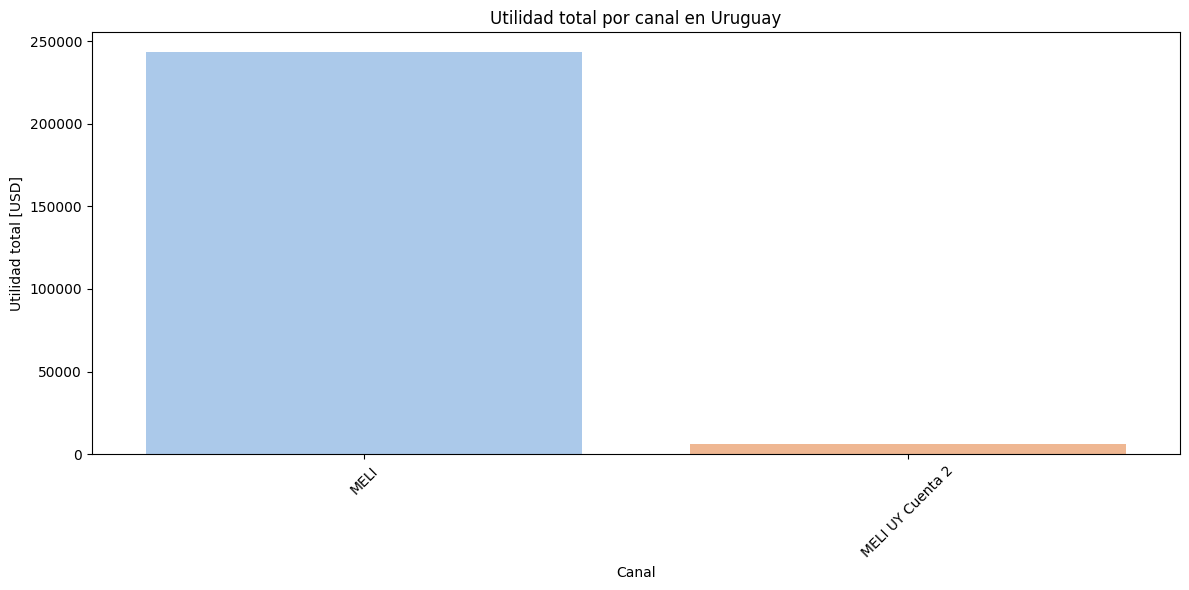

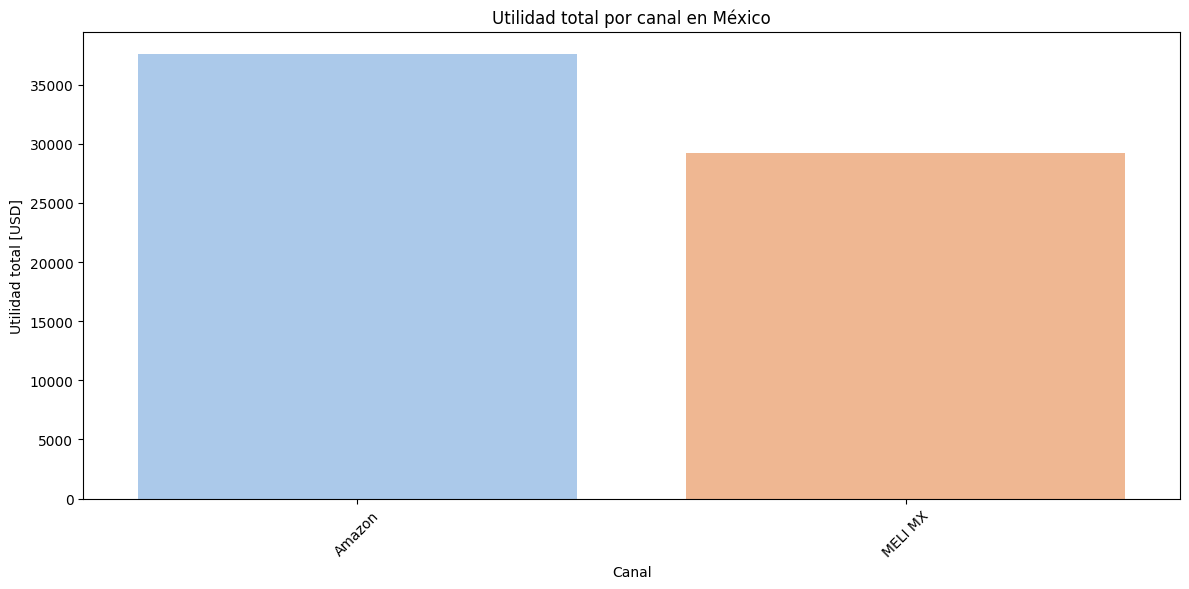

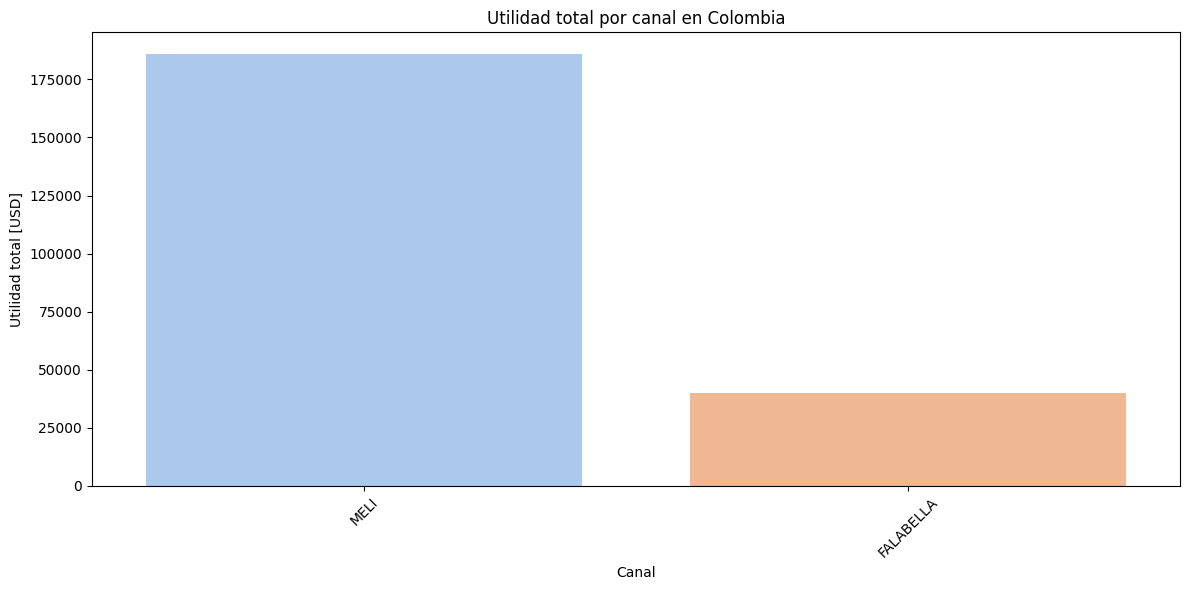

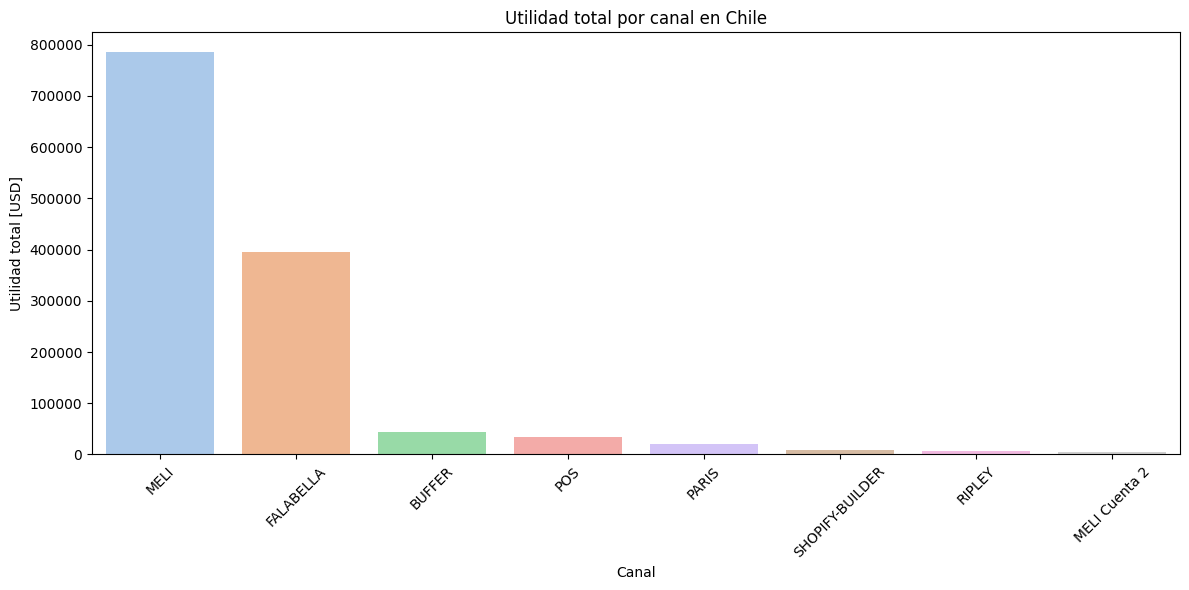

In [39]:
countries = group_by_country['País'].unique()

for country in countries:
    country_data = group_by_country[group_by_country['País'] == country]
    plt.figure(figsize=(12, 6))
    sns.barplot(data=country_data, x='Canal', y='utilidad_total', hue='Canal', palette='pastel')
    plt.title(f'Utilidad total por canal en {country.capitalize()}')
    plt.xlabel('Canal')
    plt.ylabel('Utilidad total [USD]')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [40]:
canal_mayor_utilidad = group_by_country.loc[group_by_country.groupby('País')['utilidad_total'].idxmax(), ['País', 'Canal', 'utilidad_total']].reset_index(drop=True)

print("Canal con mayor utilidad total [USD] por país:")
print(canal_mayor_utilidad.round(2))


Canal con mayor utilidad total [USD] por país:
       País   Canal  utilidad_total
0     CHILE    MELI       784914.08
1  COLOMBIA    MELI       185953.57
2    MÉXICO  Amazon        37588.89
3   URUGUAY    MELI       243339.19


A partir de las gráficas y los resultados descritos anteriormente, los mejores canales de venta por país son:

| País      | Canal  | Utilidad Total [USD] |
|-----------|--------|---------------------------|
| CHILE     | MELI   | 784914.08                  |
| COLOMBIA  | MELI   | 185953.57                 |
| MÉXICO    | Amazon | 37588.89                      |
| URUGUAY   | MELI   | 243339.19                     |


#### b. Rentabilidad por país

Graficaremos las rentabilidades generadas por cada canal por país:

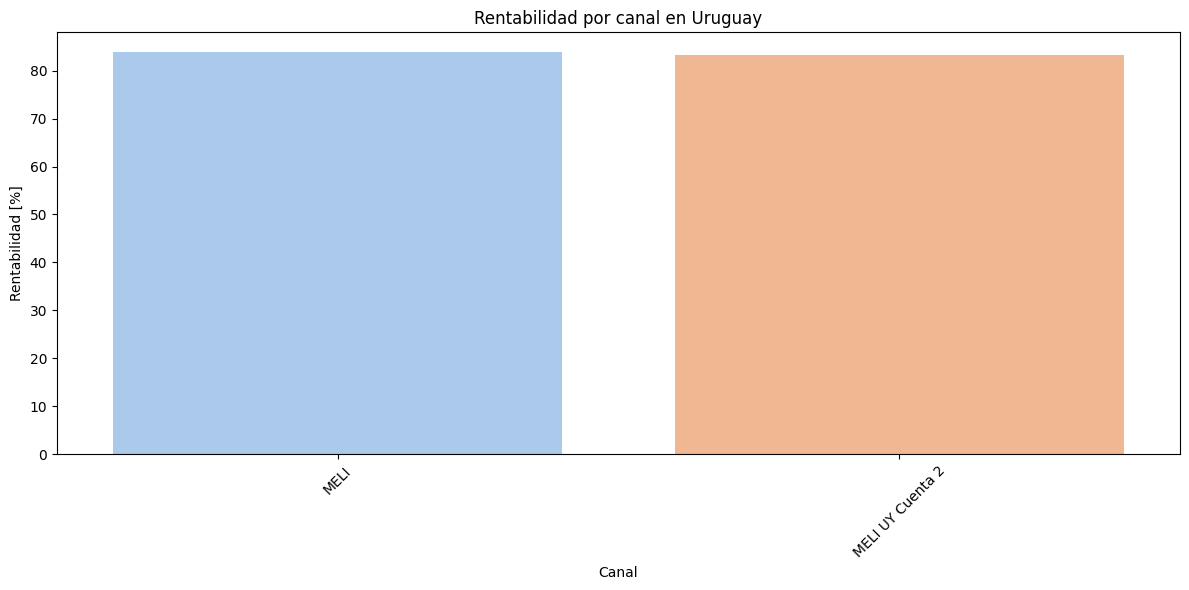

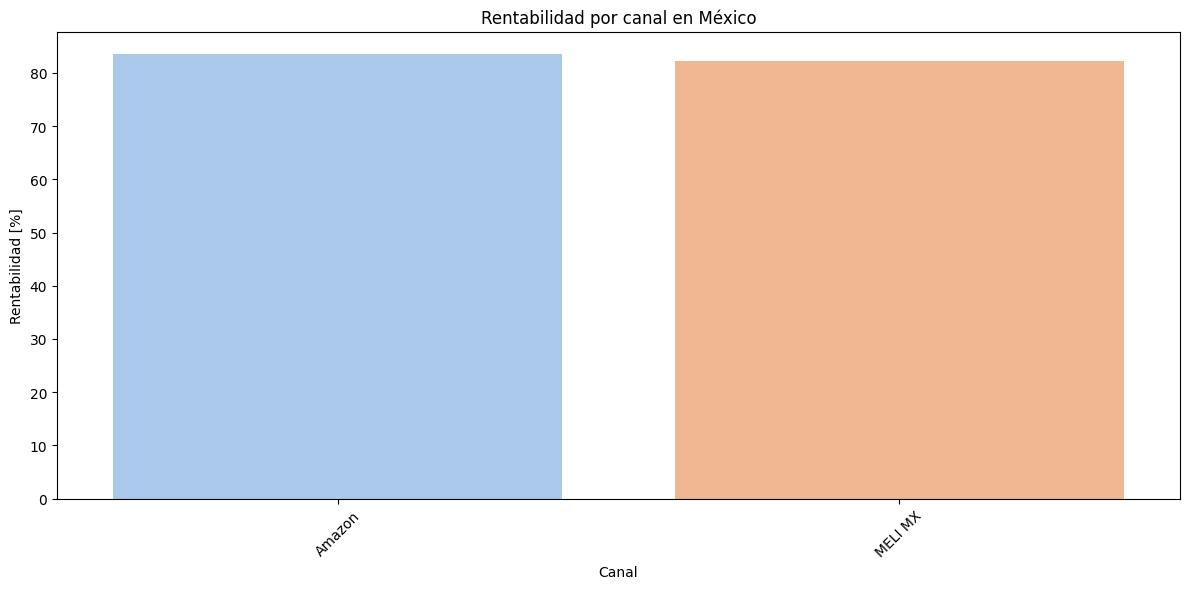

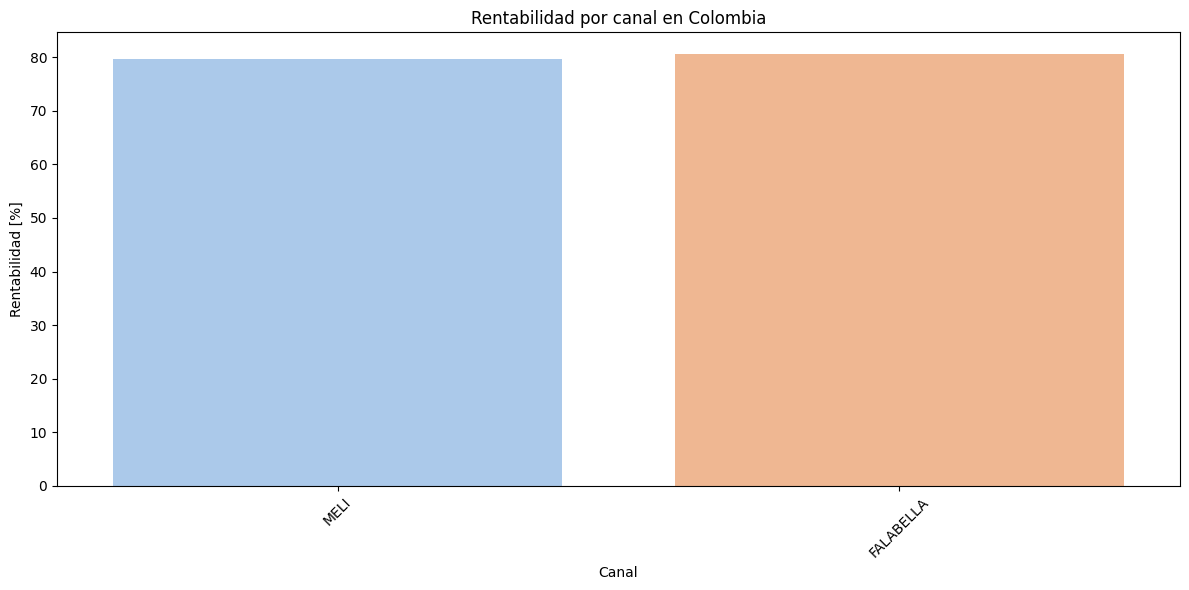

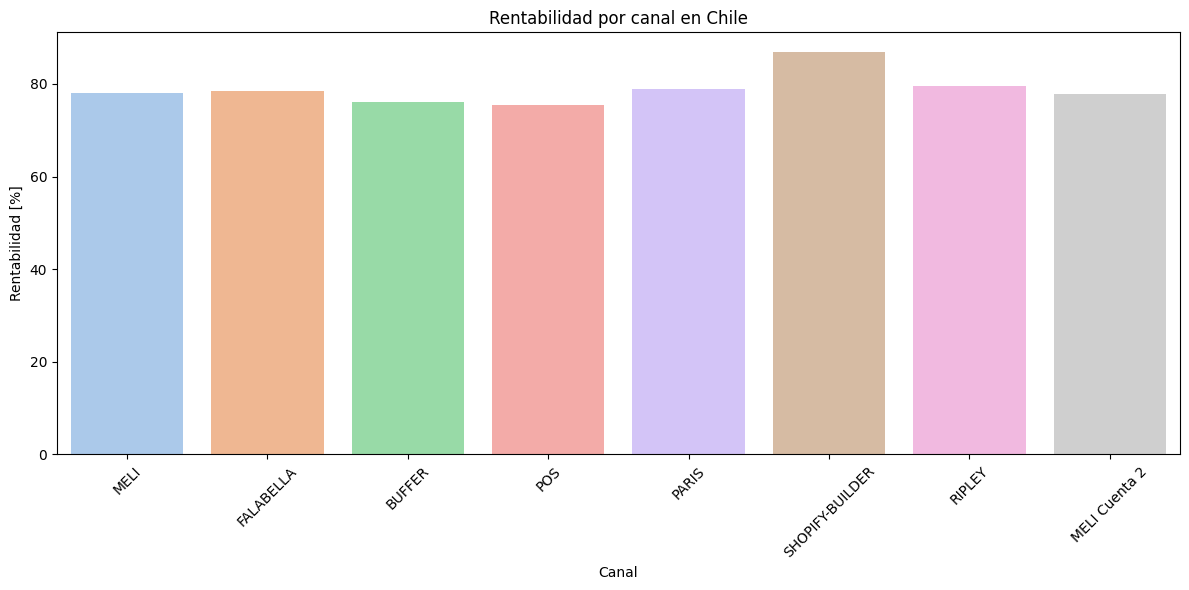

In [41]:
for country in countries:
    country_data = group_by_country[group_by_country['País'] == country]
    plt.figure(figsize=(12, 6))
    sns.barplot(data=country_data, x='Canal', y='rentabilidad', hue='Canal',  palette='pastel')
    plt.title(f'Rentabilidad por canal en {country.capitalize()}')
    plt.xlabel('Canal')
    plt.ylabel('Rentabilidad [%]')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [42]:

canal_mayor_rentabilidad = group_by_country.loc[group_by_country.groupby('País')['rentabilidad'].idxmax(), ['País', 'Canal', 'rentabilidad']].reset_index(drop=True)

print("\nCanal con mayor rentabilidad [%] por país:")
print(canal_mayor_rentabilidad.round(2))


Canal con mayor rentabilidad [%] por país:
       País            Canal  rentabilidad
0     CHILE  SHOPIFY-BUILDER         86.78
1  COLOMBIA        FALABELLA         80.60
2    MÉXICO           Amazon         83.54
3   URUGUAY             MELI         83.83


A modo de resumen, el canal con mayor rentabilidad por país es:



| País      | Canal            | Rentabilidad [%] |
|-----------|------------------|------------------|
| CHILE     | SHOPIFY-BUILDER  | 86.78            |
| COLOMBIA  | FALABELLA        | 80.60            |
| MÉXICO    | Amazon           | 83.54            |
| URUGUAY   | MELI             | 83.83            |


### Pregunta 2. Si te pidieran que generara un listado de SKUs que deberían pasar a ser obsoletos o descontinuados ¿Qué criterios usarías? Entrega un ejemplo por cada país


De forma preliminar, se puede definir que un producto obsoleto es aquel que se vendió en algún momento pasado pero ya no se vende, por ejemplo, la última vez que se vendió fue hace 1 año. Con este objetivo, primero debemos entender cuál es marco temporal del dataset para lo que se obtien la venta más antigua y la más reciente: 

In [43]:
oldest_date = df['Fecha'].min()
newest_date = df['Fecha'].max()

print(f"\nFecha más antigua: {oldest_date}")
print(f"Fecha más reciente: {newest_date}")


Fecha más antigua: 2025-03-01 00:00:00
Fecha más reciente: 2025-03-31 00:00:00


Dado que el dataset abarca solo un mes de vigencia, no resulta adecuado utilizarlo para detectar obsolescencia de productos de forma robusta.

Como alternativa, se propone un nuevo enfoque basado en el análisis de las ventas y los estados de despacho. En particular, se considera que si un producto presenta de forma recurrente estados de despacho inconclusos o fallidos —como 'Devolución en Proceso', 'En Mediación', 'Desconocido' o 'Cancelado'—, esto podría indicar una falta de stock o problemas en su disponibilidad operacional.

In [44]:
estados_inconclusos = ['Devolución en Proceso', 'En Mediación', 'Desconocido', 'Cancelado', 'Sin Información', 'Devuelto']

# Crear flag de problema
df['flag_problema'] = df['Estado de Despacho'].isin(estados_inconclusos).astype(int)

# Agrupar por país y SKU
sku_stats = df.groupby(['País', 'SKU']).agg(
    cantidad_pedidos_totales=('Estado de Despacho', 'count'),
    ocurrencias_problema=('flag_problema', 'sum'),
    estados_unicos_problema=('Estado de Despacho', lambda x: x[df.loc[x.index, 'flag_problema'] == 1].nunique()),
    fecha_reciente=('Fecha', 'max'),
    fecha_reciente_problema=('Fecha', lambda x: x[df.loc[x.index, 'flag_problema'] == 1].max())
).reset_index()

# Calcular proporción de problemas
sku_stats['proporcion_problemas'] = sku_stats['ocurrencias_problema'] / sku_stats['cantidad_pedidos_totales']

# Obtener el SKU más problemático por país
sku_mas_problematico_por_pais = sku_stats.sort_values(['País', 'proporcion_problemas'], ascending=[True, False]) \
                                         .groupby('País').head(1).reset_index(drop=True)

# Mostrar resultados
print("🔍 SKU más problemático por país:")
print(sku_mas_problematico_por_pais[[
    'País',
    'SKU',
    'cantidad_pedidos_totales',
    'ocurrencias_problema',
    'proporcion_problemas',
    'fecha_reciente',
    'fecha_reciente_problema'
]])


🔍 SKU más problemático por país:
       País       SKU  cantidad_pedidos_totales  ocurrencias_problema  \
0     CHILE  BB436292                         1                     1   
1  COLOMBIA  BD158018                         1                     1   
2    MÉXICO  BE470852                         6                     1   
3   URUGUAY  BE033243                         3                     1   

   proporcion_problemas fecha_reciente fecha_reciente_problema  
0              1.000000     2025-03-30              2025-03-30  
1              1.000000     2025-03-26              2025-03-26  
2              0.166667     2025-03-29              2025-03-02  
3              0.333333     2025-03-21              2025-03-21  


Considerando esta información, se puede realizar un segundo análisis a los dos SKU que han tenido más problemas en sus ventas: SKU BB436292 y SKU BD092039, que coincide con ser productos con pocos pedidos totales: 

In [45]:
skus_criticos = ['BB436292', 'BD092039']

df_criticos = df[df['SKU'].isin(skus_criticos)][['País','Fecha', 'SKU', 'Estado de Despacho']].sort_values(by=['SKU', 'Fecha'], ascending=True)

print(df_criticos)


        País      Fecha       SKU Estado de Despacho
83485  CHILE 2025-03-30  BB436292    Sin Información
62276  CHILE 2025-03-21  BD092039    Sin Información


Dado que los **SKU BB436292 y SKU BD092039** casi no tienen ventas y estos no tienen información del estado del despacho, se puede inferir que estos son **dos SKU obsoletos**. 

### Pregunta 3. Si estuvieras a cargo de la distribución de los productos dentro de cada país ¿Qué criterios usarías para alocar? Entrega un ejemplo por cada país.

Dado que se tiene una cantidad limitada de productos que distribuir, el problema logístico consiste en decidir qué productos enviar a cada canal o plataforma de venta (por ejemplo, Mercado Libre, Falabella, tienda física, etc.) a modo de maximizar la rentabilidad y eficiencia operativa. Los crtierios que utilizaría con este objetivo son los siguientes: 

1. Rentabilidad por canal: priorizar productos en canales donde el margen por unidad es mayor. $$\text{Rentabilidad unitaria del SKU}=\frac{\text{Utilidad total SKU}}{\text{Unidades totales vendidas SKU}} $$

2. Historial de ventas: asignar mayor inventario a canales donde ciertos productos tienen alta rotación.

3. Tasa de devoluciones o fallos de despacho: evitar asignar productos a canales con alta tasa de fallos para esos SKU.

Una forma de considerar estos elementos, es mediante la asignación de pesos a cada variable, vale decir, la asignación se hará considerando un ponderado de estas tres variables. Con este objetivo, se agrupan y normalizan las variables a modo de que la escala no influyan en el resultado. La asignación de los pesos será la siguiente: 

- Rentabilidad unitaria (rentabilidad_unitaria): peso 0.6
Se prioriza con mayor fuerza, ya que permite identificar los canales más rentables para un SKU específico.

- Cantidad de productos vendidos (unidades_vendidas): peso 0.4
Refleja la capacidad del canal para movilizar inventario y generar volumen.

- Tasa de devoluciones (tasa_devolucion): peso -0.4
Se penaliza las devoluciones, ya que se busca evitar asignar productos a canales con alta incidencia de problemas de última milla.

Considerando los pesos anteriores, la formula del scoring de Prioridad de Asignación está dada por: 

$$
\text{Prioridad Asignación} = 
(0.6 \times \text{Rentabilidad Normalizada}) + 
(0.4 \times \text{Ventas Normalizada}) - 
(0.4 \times \text{Tasa devolución Normalizada})
$$




_Disclaimer_: Se supone que no existen acuerdos comerciales con los centros de distribución que obliguen a tener un mínimo de distribución o limiten la oferta. 

In [46]:
df['flag_devolucion'] = df['Estado de Despacho'].isin(estados_inconclusos).astype(int)

df_alocacion = df.groupby(['País', 'Canal', 'SKU']).agg(
    monto_total_sum=('Monto Total', 'sum'),
    costo_despacho_sum=('Costo de Despacho', 'sum'),
    comision_sum=('Comisión', 'sum'),
    utilidad_total=('utilidad', 'sum'),
    unidades_vendidas=('Unid. Vend.', 'sum'),
    tasa_devolucion=('flag_devolucion', 'mean')
).reset_index()

df_alocacion["rentabilidad"] = df_alocacion['utilidad_total'] / df_alocacion['monto_total_sum']*100
df_alocacion['rentabilidad_unitaria'] = df_alocacion['utilidad_total'] / df_alocacion['unidades_vendidas']

df_alocacion['tasa_devolucion'] = df_alocacion['tasa_devolucion'] * 100 


scaler = MinMaxScaler()

df_alocacion[['rentabilidad_norm', 'ventas_norm', 'devolucion_norm']] = scaler.fit_transform(
    df_alocacion[['rentabilidad_unitaria', 'unidades_vendidas', 'tasa_devolucion']]
)

df_alocacion['prioridad_asignacion'] = (
    0.6 * df_alocacion['rentabilidad_norm'] +
    0.4 * df_alocacion['ventas_norm'] -
    0.4 * df_alocacion['devolucion_norm']
)


df_alocacion = df_alocacion.sort_values(by='prioridad_asignacion', ascending=False)




Se prueba el sistema de Asignación para el SKU más vendido por país:

In [47]:
for country in countries:
    country_data = df_alocacion[df_alocacion['País'] == country]
    top_sku = country_data.loc[country_data['unidades_vendidas'].idxmax(), 'SKU']
    sku_data = country_data[country_data['SKU'] == top_sku]
    
    canal_prioridad = ( sku_data[['Canal', 'prioridad_asignacion']].sort_values(by='prioridad_asignacion', ascending=False).reset_index(drop=True))

    print(f"\n País: {country} - SKU: {top_sku}")
    print("Canales ordenados por prioridad de asignación:")
    print(canal_prioridad.round(3).to_string(index=False))
    
    



 País: URUGUAY - SKU: BD971810
Canales ordenados por prioridad de asignación:
Canal  prioridad_asignacion
 MELI                 0.166

 País: MÉXICO - SKU: BD470609
Canales ordenados por prioridad de asignación:
  Canal  prioridad_asignacion
MELI MX                 0.203
 Amazon                 0.184

 País: COLOMBIA - SKU: BE032659
Canales ordenados por prioridad de asignación:
    Canal  prioridad_asignacion
     MELI                 0.215
FALABELLA                 0.124

 País: CHILE - SKU: BE381356
Canales ordenados por prioridad de asignación:
          Canal  prioridad_asignacion
           MELI                 0.497
      FALABELLA                 0.226
          PARIS                 0.102
         RIPLEY                 0.093
SHOPIFY-BUILDER                -0.313


A modo de resumen del ejercicio, se identificó el SKU más vendido en cada país y se ordenaron sus canales según la prioridad de asignación, considerando rentabilidad, rotación y tasa de devolución:

| País     | SKU       | Canal Prioritario | Score Prioritario | Otros Canales (con score)                                                                 |
|----------|-----------|-------------------|-------------------|--------------------------------------------------------------------------------------------|
| Uruguay  | BD971810  | MELI              | 0.166            | Solo un canal disponible; asignación directa                                              |
| México   | BD470609  | MELI MX           | 0.203           | Amazon (0.184)                                                                            |
| Colombia | BE032659  | MELI              | 0.215             | Falabella (0.124)                                                                         |
| Chile    | BE381356  | MELI              | 0.497            | Falabella (0.226), Paris (0.102), Ripley (0.093), Shopify-Builder (-0.313, evitar alocar) |

Nota: si algún canal no aparece en la priorización, es debido a que el SKU no se vende en este canal. 


### Pregunta 4. Realizando un análisis de costos entre Chile y Colombia, ¿Qué principales diferencias ves? ¿Qué conclusiones podemos sacar de ellas?


Para analizar las diferencias en los costos, se analizará el costo promedio de comisión y envió.  podemos separar el análisis es tres: analizar la totalidad de los canale y comparar los canales comunes  (para comprobar si a pesar de tener el mismo proveedor se cobra más en un país):


Canales de ventas en Chile: []
0 canales de ventas en Chile

Canales de ventas en Chile: []
0 canales de ventas en Chile
Comparación promedio de indicadores entre Chile y Colombia:
       País  Costo despacho promedio  Comisión promedio  Costo Total promedio  \
0     Chile                     1.95               2.09                  4.05   
1  Colombia                     1.92               2.39                  4.31   

   Monto total promedio  Unidades vendidas promedio  
0                 18.55                        1.12  
1                 21.31                        1.13  


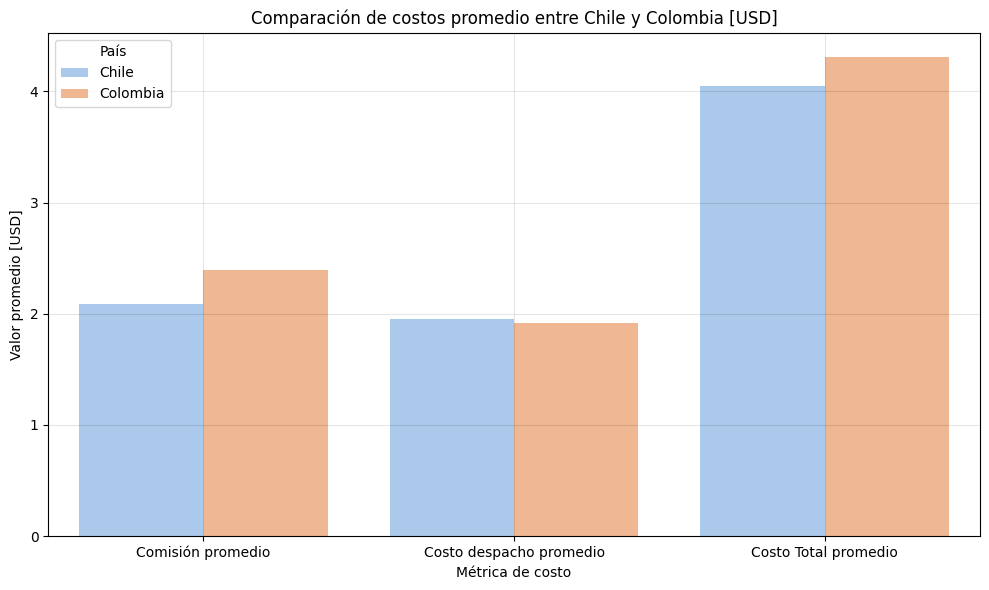

In [48]:
chile_colombia_df = df[df['País'].isin(['CHILE', 'COLOMBIA'])].copy()
chile_colombia_df['País'] = chile_colombia_df['País'].str.capitalize()

chile_colombia_df["Costo Total"] = chile_colombia_df["Costo de Despacho"] + chile_colombia_df["Comisión"]

canales_ventas_chile = [canal.capitalize() for canal in chile_colombia_df[chile_colombia_df['País'] == 'CHILE']['Canal'].unique()]
print("\nCanales de ventas en Chile:", canales_ventas_chile)
print(len(canales_ventas_chile), "canales de ventas en Chile")

canales_ventas_chile = [canal.capitalize() for canal in chile_colombia_df[chile_colombia_df['País'] == 'COLOMBIA']['Canal'].unique()]
print("\nCanales de ventas en Chile:", canales_ventas_chile)
print(len(canales_ventas_chile), "canales de ventas en Chile")


comparacion = chile_colombia_df.groupby('País').agg(
    costo_despacho_promedio=('Costo de Despacho', 'mean'),
    comision_promedio=('Comisión', 'mean'),
    costo_total_promedio=("Costo Total", 'mean'),
    
    monto_total_promedio=('Monto Total', 'mean'),
    unidades_vendidas_promedio=('Unid. Vend.', 'mean')
    
).round(2).reset_index()

comparacion.rename(columns={
    'costo_despacho_promedio': 'Costo despacho promedio',
    'comision_promedio': 'Comisión promedio',
    'monto_total_promedio': 'Monto total promedio',
    'unidades_vendidas_promedio': 'Unidades vendidas promedio',
    'costo_total_promedio': "Costo Total promedio"
}, inplace=True)

print("Comparación promedio de indicadores entre Chile y Colombia:")
print(comparacion)

comparacion_melt = comparacion.melt(id_vars='País', 
                                     value_vars=['Comisión promedio', 'Costo despacho promedio',  "Costo Total promedio"],
                                     var_name='Indicador', 
                                     value_name='Valor')


plt.figure(figsize=(10, 6))
sns.barplot(data=comparacion_melt, x='Indicador', y='Valor', hue='País', palette='pastel')
plt.title('Comparación de costos promedio entre Chile y Colombia [USD]')
plt.ylabel('Valor promedio [USD]')
plt.xlabel('Métrica de costo')
plt.tight_layout()
plt.grid(True, color='black', alpha=0.1)
plt.show()





Colombia presenta un mayor costo total promedio en comparación con Chile, impulsado principalmente por una comisión promedio más alta, mientras que los costos de despacho son prácticamente iguales en ambos países. 

Para complementar el análisis, se puede comparar solo los canales comunes: 

Comparación promedio de indicadores entre Chile y Colombia (solo canales comunes):
       País  Costo despacho promedio  Comisión promedio  Costo Total promedio  \
0     CHILE                     1.96               2.11                  4.06   
1  COLOMBIA                     1.92               2.39                  4.31   

   Monto total promedio  Unidades vendidas promedio  
0                 18.68                        1.13  
1                 21.31                        1.13  


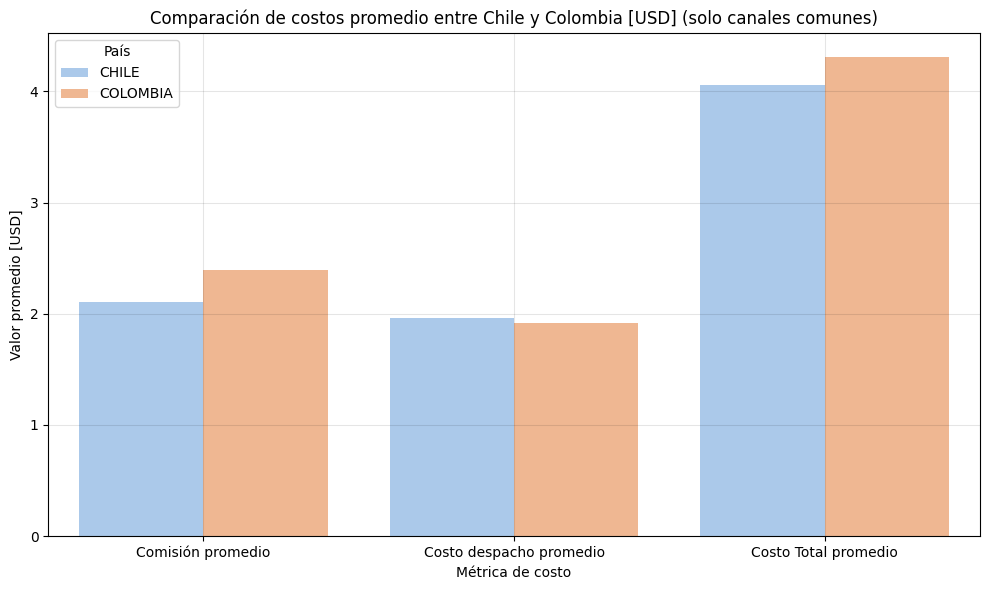

In [49]:

chile_colombia_df = df[df['País'].isin(['CHILE', 'COLOMBIA'])].copy()

canales_chile = set(df[df['País'] == 'CHILE']['Canal'].unique())
canales_colombia = set(df[df['País'] == 'COLOMBIA']['Canal'].unique())
canales_comunes = canales_chile.intersection(canales_colombia)


chile_colombia_df = chile_colombia_df[chile_colombia_df['Canal'].isin(canales_comunes)]


chile_colombia_df["Costo Total"] = chile_colombia_df["Costo de Despacho"] + chile_colombia_df["Comisión"]

# Agrupar y calcular promedios
comparacion = chile_colombia_df.groupby('País').agg(
    costo_despacho_promedio=('Costo de Despacho', 'mean'),
    comision_promedio=('Comisión', 'mean'),
    costo_total_promedio=('Costo Total', 'mean'),
    monto_total_promedio=('Monto Total', 'mean'),
    unidades_vendidas_promedio=('Unid. Vend.', 'mean')
).round(2).reset_index()


comparacion.rename(columns={
    'costo_despacho_promedio': 'Costo despacho promedio',
    'comision_promedio': 'Comisión promedio',
    'costo_total_promedio': 'Costo Total promedio',
    'monto_total_promedio': 'Monto total promedio',
    'unidades_vendidas_promedio': 'Unidades vendidas promedio'
}, inplace=True)


print("Comparación promedio de indicadores entre Chile y Colombia (solo canales comunes):")
print(comparacion)


comparacion_melt = comparacion.melt(
    id_vars='País', 
    value_vars=['Comisión promedio', 'Costo despacho promedio', 'Costo Total promedio'],
    var_name='Indicador', 
    value_name='Valor'
)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=comparacion_melt, x='Indicador', y='Valor', hue='País', palette='pastel')
plt.title('Comparación de costos promedio entre Chile y Colombia [USD] (solo canales comunes)')
plt.ylabel('Valor promedio [USD]')
plt.xlabel('Métrica de costo')
plt.tight_layout()
plt.grid(True, color='black', alpha=0.1)
plt.show()


Los resultados mantienen la tendencia enunciada previamente. Esta diferencia sugiere que, aunque la ditribución se mantiene estandarizada, las condiciones comerciales en Colombia son peores que las de Chile lo que impacta en la rentabilidad. En este contexto, se recomienda generar nuevos acuerdos con los canales de venta en ese mercado.

### Pregunta 5. Si te pidieran armar un forecast de venta para cada país con la información que tienes, ¿Cómo armarías el modelo? ¿Qué supuestos usarías?


Se desea proyectar las ventas en un horizonte de tiempo de 3 meses a partir de la data proporcionada.

Dado que los datos tienen una cobertura limitada (de un mes), la construcción de un modelo de forecast de venta modelos predictores más complejos como _Redes Neuronales_ no serían apropiados dado que necesitan una cantidad significativa de datos para capturar la estacionalidad y tendencias. En este contexto, modelos como  _Random Forest Regressor_ podrían cumplir el objetivo de forma robusta dado que son robustos para series temporales incompletas. 

Con este obejtivo, se agrupará por país y día a modo de calcular cuánto se vendió en cada día del mes y generar una Serie Temporal. Además se crean las siguientes variables para dar un mayor contexto al modelo y que le permita identificar estacionalidad y patrones: 

- `weekday`: Día de la semana (0 = lunes, 6 = domingo). Permite capturar ciclos semanales, por ejemplo, si las ventas suben los fines de semana o bajan los lunes.
- `day`: Día del mes (1 a 31). Permite detectar efectos de fin o principio de mes.

In [50]:
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

ventas_diarias = df.groupby(['País', df['Fecha'].dt.date]).agg(
    monto_total_diario=('Monto Total', 'sum')
).reset_index().rename(columns={'Fecha': 'fecha'})

ventas_diarias['fecha'] = pd.to_datetime(ventas_diarias['fecha'])


Realizamos la predicción y graficamos para visualizar la tendencia: 

📊 Desempeño del modelo en URUGUAY:
MAE  (Error Absoluto Medio): 713
RMSE (Raíz Error Cuadrático Medio): 859
MAPE (Error Porcentual Absoluto Medio): 9.71%
📊 Desempeño del modelo en MÉXICO:
MAE  (Error Absoluto Medio): 203
RMSE (Raíz Error Cuadrático Medio): 226
MAPE (Error Porcentual Absoluto Medio): 7.31%
📊 Desempeño del modelo en COLOMBIA:
MAE  (Error Absoluto Medio): 1,445
RMSE (Raíz Error Cuadrático Medio): 1,627
MAPE (Error Porcentual Absoluto Medio): 16.34%
📊 Desempeño del modelo en CHILE:
MAE  (Error Absoluto Medio): 4,768
RMSE (Raíz Error Cuadrático Medio): 6,207
MAPE (Error Porcentual Absoluto Medio): 9.38%


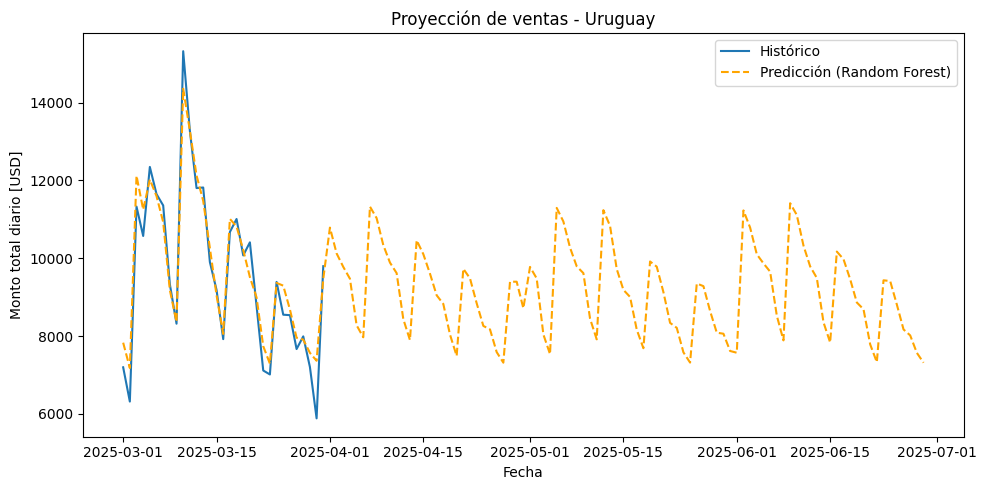

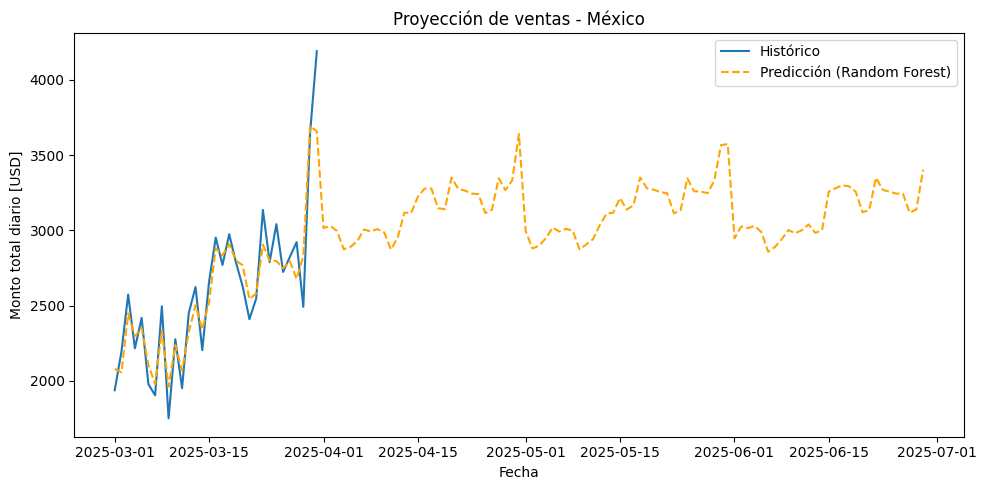

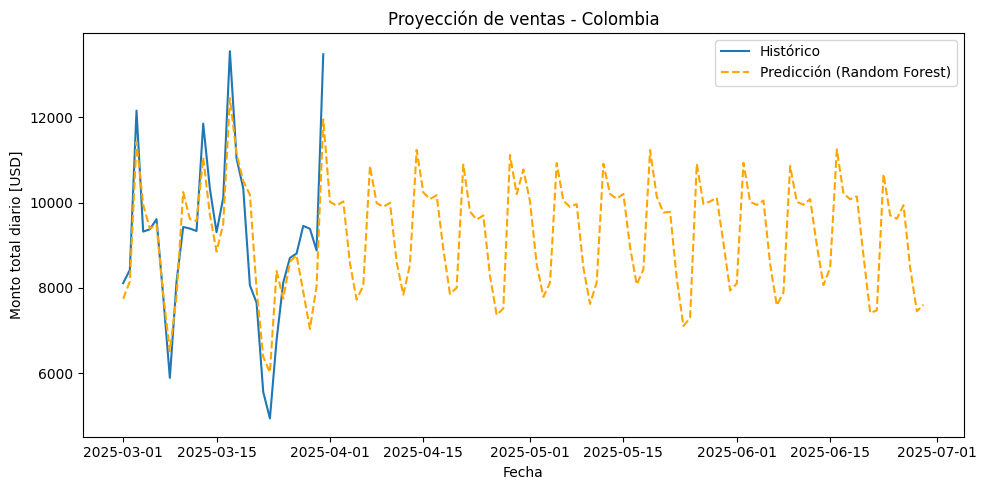

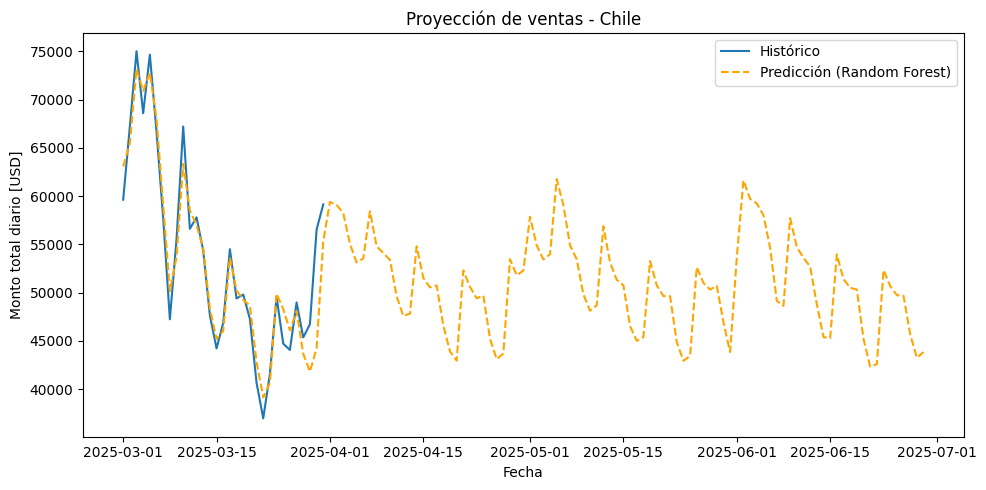

In [61]:

ventas_3_meses = defaultdict(list)
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')
for pais in countries:
    df_pais = ventas_diarias[ventas_diarias['País'] == pais].copy()
    df_pais = df_pais.sort_values('fecha')

    df_pais['dias'] = (df_pais['fecha'] - df_pais['fecha'].min()).dt.days
    df_pais['weekday'] = df_pais['fecha'].dt.weekday
    df_pais['day'] = df_pais['fecha'].dt.day
    
    X = df_pais[['dias', 'weekday', 'day']]
    y = df_pais['monto_total_diario']

    
    ultimo_tercio = df_pais[df_pais['fecha'].dt.day >= 20]


    df_validacion = ultimo_tercio.sample(n=5, random_state=42)

    df_entrenamiento = df_pais.drop(df_validacion.index)

    X_train = df_entrenamiento[['dias', 'weekday', 'day']]
    y_train = df_entrenamiento['monto_total_diario']

    X_val = df_validacion[['dias', 'weekday', 'day']]
    y_val = df_validacion['monto_total_diario']
    
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    print(f"📊 Desempeño del modelo en {pais}:")
    print(f"MAE  (Error Absoluto Medio): {mae:,.0f}")
    print(f"RMSE (Raíz Error Cuadrático Medio): {rmse:,.0f}")
    print(f"MAPE (Error Porcentual Absoluto Medio): {mape*100:.2f}%")


    dias_futuros = np.arange(df_pais['dias'].max() + 1, df_pais['dias'].max() + 91)
    fechas_futuras = [df_pais['fecha'].max() + pd.Timedelta(days=i) for i in range(1, 91)]



    X_futuro = pd.DataFrame({
        'dias': dias_futuros,
        'weekday': [f.weekday() for f in fechas_futuras],
        'day': [f.day for f in fechas_futuras]
    })

    y_futuro = modelo.predict(X_futuro)

    fechas_todas = pd.date_range(start=df_pais['fecha'].min(), end=df_pais['fecha'].max() + pd.Timedelta(days=90))

    dias_todas = (fechas_todas - df_pais['fecha'].min()).days

    X_todo = pd.DataFrame({
        'dias': dias_todas,
        'weekday': fechas_todas.weekday,
        'day': fechas_todas.day
    })


    y_todo = modelo.predict(X_todo)

    serie_real = df_pais.set_index('fecha')['monto_total_diario'].reindex(fechas_todas)

    serie_pred = pd.Series(data=y_todo, index=fechas_todas)
    
    df_forecast = pd.DataFrame({
        'País': pais,
        'fecha': fechas_futuras,
        'prediccion_monto': y_futuro
    })
    
    
    df_forecast['mes'] = df_forecast['fecha'].dt.strftime('%B')
    df_forecast['año'] = df_forecast['fecha'].dt.year
    resumen = df_forecast.groupby(['año', 'mes'])['prediccion_monto'].sum().reset_index()

    # Guardar resultados
    ventas_3_meses[pais] = resumen

  
    plt.figure(figsize=(10, 5))
    plt.plot(serie_real.index, serie_real.values, label='Histórico')
    plt.plot(serie_pred.index, serie_pred.values, '--', label='Predicción (Random Forest)', color='orange')
    plt.title(f'Proyección de ventas - {pais.capitalize()}')
    plt.xlabel('Fecha')
    plt.ylabel('Monto total diario [USD]')
    plt.legend()
    plt.tight_layout()
plt.show()




In [60]:
for pais, resumen in ventas_3_meses.items():
    print(f"\n{pais.upper().capitalize()}:")
    for _, row in resumen.iterrows():
        print(f"  {row['mes'].capitalize()} {row['año']}: ${row['prediccion_monto']:,.0f}")


Uruguay:
  Abril 2025: $303,140
  Junio 2025: $291,039
  Mayo 2025: $309,906

México:
  Abril 2025: $76,311
  Junio 2025: $73,562
  Mayo 2025: $78,621

Colombia:
  Abril 2025: $277,577
  Junio 2025: $266,960
  Mayo 2025: $283,292

Chile:
  Abril 2025: $1,494,915
  Junio 2025: $1,443,571
  Mayo 2025: $1,529,385


El resumen de las ventas totales pronosticado para los próximos 3 meses es el siguiente: 

| País     | Abril 2025 [USD]| Mayo 2025 [USD] | Junio 2025 [USD]|
|----------|------------|-----------|------------|
| Uruguay  | $268,791   | $273,536  | $258,211   |
| México   | $94,071    | $97,430   | $90,363    |
| Colombia | $294,193   | $303,009  | $283,209   |
| Chile    | $1,602,961 | $1,652,562| $1,547,179 |
